### MSc Dissertation project
#### September, 2023
#### Meat Freshness Detection using Transfer Learning
#### Task1 - Singlepiece dataset
#### Author - Indulekha Arun

In [1]:
# To suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow
# Set a random seed - to make the results reproducible
seed = 42
tensorflow.random.set_seed(seed)

In [3]:
# Load the python libraries
import os
import cv2
from glob import glob
import pandas as pd
from datetime import datetime


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# To test the fine-tuned model on images from the internet
from PIL import Image
import requests
from io import BytesIO

In [4]:
print('tensorflow: ',tensorflow.__version__)
print('tensorflow.keras: %s' % keras.__version__)

tensorflow:  2.12.0
tensorflow.keras: 2.12.0


In [5]:
# Define the paths for the image data directories - a single piece of raw meat in one image
# Dataset - Meat Freshness Image Dataset by VINAYAK SHANAWAD
# Source - https://www.kaggle.com/datasets/vinayakshanawad/meat-freshness-image-dataset
# Classes - Fresh, Half-Fresh and Spoiled. We will be considering only Fresh and Spoiled
data_dir = '/kaggle/input/meat-freshness-image-dataset/Meat Freshness.v1-new-dataset.multiclass/'
train_dir = glob(data_dir + 'train/*.jpg')
test_dir = glob(data_dir + 'valid/*.jpg')

In [6]:
print('Files/folders in the parent directory: ',os.listdir(data_dir))
print('Image files in the Train directory: ',len(train_dir))
print('Image files in the Test directory: ',len(test_dir))

Files/folders in the parent directory:  ['README.dataset.txt', 'valid', 'train']
Image files in the Train directory:  1815
Image files in the Test directory:  451


## EDA Images

In [7]:
# Read the CSV file inside the 'train' folder
# This file contains information about the classes i.e., Fresh, Half-Fresh and	Spoiled
train_classes = pd.read_csv('/kaggle/input/meat-freshness-image-dataset/Meat Freshness.v1-new-dataset.multiclass/train/_classes.csv')
train_classes.head()

filename   Fresh   Half-Fresh  \
0  SPOILED-207-_JPG.rf.4e9025c18a5ae21defb30242a6...       0            0   
1  SPOILED-261-_JPG.rf.4effa4dd0d8c2fe5579aa5859e...       0            0   
2  FRESH-202-_JPG.rf.4f13e1b8c1559b63d140d2942697...       1            0   
3  FRESH-721-_JPG.rf.4f770a93bd104098aa7ffb172a90...       1            0   
4  FRESH-904-_JPG.rf.4f66185dbff0f068ed39414bfdf1...       1            0   

    Spoiled  
0         1  
1         1  
2         0  
3         0  
4         0

#### We are only interested in the FRESH and SPOILED image classes. We will not be considering HALF-FRESH class.

In [8]:
# Remove the images with HALF-FRESH class
def remove_half_fresh(image_dir):
    new_image_dir = []
    for i in range(len(image_dir)):
        if 'HALF-FRESH' in image_dir[i]:
            continue
        new_image_dir.append(image_dir[i])
    return new_image_dir

In [9]:
train_dir = remove_half_fresh(train_dir)
test_dir = remove_half_fresh(test_dir)

In [10]:
print('Images in train directory now: ', len(train_dir))
print('Images in test directory now: ', len(test_dir))

Images in train directory now:  1185
Images in test directory now:  292


In [11]:
# Check the distribution of the classes (FRESH and SPOILED) within the training set

plot_list = []
plot_dict={}
fresh = 0
spoiled = 0
for filename in train_dir:
    if 'FRESH' in filename:
        fresh=fresh+1
    elif 'SPOILED' in filename:
        spoiled=spoiled+1


plot_dict = {'Fresh':fresh, 'Spoiled':spoiled}
print(plot_dict)

{'Fresh': 675, 'Spoiled': 510}


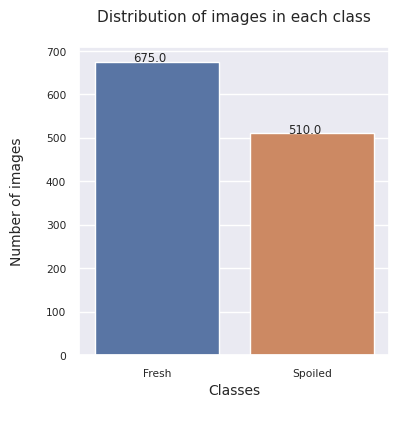

In [12]:
plot_df = pd.DataFrame([plot_dict])
plt.figure(figsize=(4,4))
sns.set(font_scale = .7)
ax = sns.barplot(data=plot_df)

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01), rotation=0)
plt.ylabel('Number of images\n', fontsize=10)
plt.xlabel('Classes\n', fontsize=10)
plt.title('Distribution of images in each class\n', fontsize=11)
plt.show()

#### The classes are almost balanced , 675-510 = 165.

In [13]:
# Display few images of both the classes
fresh, spoiled = [],[]
for filename in train_dir:
    if 'FRESH' in filename:
        fresh.append(filename)
    elif 'SPOILED' in filename:
        spoiled.append(filename)


plt.figure(figsize=(9, 9))
# Plot FRESH images
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(plt.imread(fresh[i]))
    plt.title('Fresh')
    plt.axis('off')
    
# Plot SPOILED images
for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.imshow(plt.imread(spoiled[i]))
    plt.title('Spoiled')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

##### As per the README file, the images are of the size 416x416

In [14]:
# Create a label encoded dictionary for the classes
class_labels_dict = {
    'FRESH': 1,
    'SPOILED': 0
}

In [15]:
class_labels_dict

{'FRESH': 1, 'SPOILED': 0}

In [16]:
# Create lists to hold the images and their corresponding labels
X , y = [] , [] #to split for training and validation
x_test , y_test = [] , [] #only for testing

### Preprocessing the images

In [17]:
# Function to perform data pre-processing
# 1. Read the image using cv2 (natively read as a numpy array).
# 2. Resize the image using interpolation=cv2.INTER_AREA - to maintain the ascept ratio as much as possible.
      # According to the official documentation page of open cv - for interpolation "To shrink an image, it will generally look best with CV_INTER_AREA interpolation"
      # https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#cv2.resize
# 3. Change from BGR to RGB color channel

image_size = 224

def data_preprocessing(image_dir):
    preprocessed_image = []
    preprocessed_label = []
    
    for filename in image_dir:
        
        if '/FRESH' in filename:
            class_name = 'FRESH'
        else:
            class_name = 'SPOILED'

        img = cv2.imread(filename)
        img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        preprocessed_image.append(img)
        preprocessed_label.append(class_labels_dict[class_name])
    return preprocessed_image,preprocessed_label

In [18]:
# Dataset for training (and validation)
X, y = data_preprocessing(train_dir)
print('Len of X : ', len(X))
print('Len of y : ', len(y))

Len of X :  1185
Len of y :  1185


In [19]:
# Dataset for testing
x_test, y_test = data_preprocessing(test_dir)
print('Len of x_test : ', len(x_test))
print('Len of y_test : ', len(y_test))

Len of x_test :  292
Len of y_test :  292


0


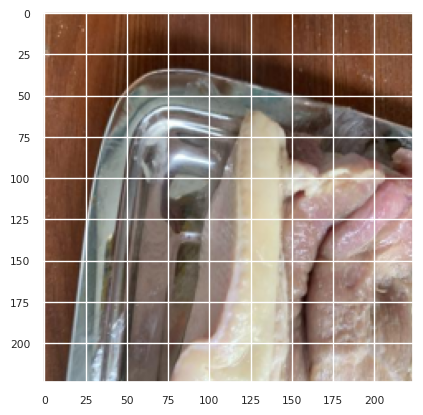

In [20]:
# Display some images after preprocessing
plt.imshow(X[0])
print(y[0])

0


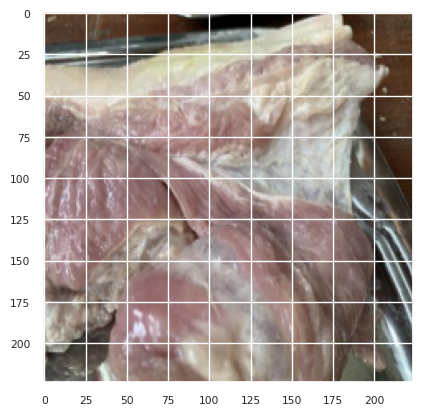

In [21]:
# Display some images after preprocessing
plt.imshow(X[2])
print(y[2])

In [22]:
plt.imshow(x_test[0])
print(y_test[0])

1


In [23]:
# Perform train test split with stratify to maintain the class distribution
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [24]:
# Convert to NumPy array for quick and efficient working with the deep models
x_train = np.array(x_train)
x_val = np.array(x_val)

In [25]:
print('Shape of x_train : ', x_train.shape)
print('len of y_train   : ', len(y_train))
print('Shape of x_val   : ', x_val.shape)
print('len of y_val     : ', len(y_val))

Shape of x_train :  (829, 224, 224, 3)
len of y_train   :  829
Shape of x_val   :  (356, 224, 224, 3)
len of y_val     :  356


In [26]:
# Performing one hot encoding before training
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

In [27]:
y_train[0]
# y_train has been converted to a binary class matrix representation

array([1., 0.], dtype=float32)

### Data Augmentation

In [28]:
# Use ImageDataGenerator to create augmentations
datagen = ImageDataGenerator(dtype = 'float32',
            preprocessing_function=tensorflow.keras.applications.resnet.preprocess_input,
            rotation_range=40,
            zoom_range=0.4,
            horizontal_flip=True, vertical_flip=True,
            width_shift_range = 0.2,height_shift_range = 0.2,
            shear_range=0.5,
            fill_mode='nearest'
            )

In [29]:
# Display samples of augmented images
augmented_images = datagen.flow(x_train, batch_size=1, shuffle=False)

# Plot the first 6 augmented images
plt.figure(figsize=(12, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    augmented_image = augmented_images.next()[0]
    plt.imshow(augmented_image)
    plt.axis('off')
    plt.title(f'Augmented Image {i+1}')

plt.tight_layout()
plt.show()

### Build the model

In [30]:
from tensorflow.keras.applications import ResNet50

In [31]:
accuracies_dict={}
accuracies_list = []

In [32]:
# Using pre-trained model as a feature extractor for classification
my_model = 'ResNet50'
if my_model == 'ResNet50':
    pretrained_model= ResNet50(
                    include_top=False,
                    input_shape=(image_size,image_size,3),
                    weights='imagenet')


# Freeze the base_model
pretrained_model.trainable = False

# Create new model on top
inputs = tensorflow.keras.Input(shape=(image_size, image_size, 3))
x = inputs

# The pre-trained model contains batch-normalization layers. These need to be kept in inference mode
# The pre-trained model would be running in inference mode, when unfreezed for fine-tuning, 
x = pretrained_model(x, training=False)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dropout(0.5, seed = seed)(x)  # Regularize with dropout

outputs = tensorflow.keras.layers.Dense(2, activation = 'softmax')(x)
model = tensorflow.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_____________________________________________

In [34]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer = optimizers.Adam(learning_rate=base_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
initial_epochs=10
batch_size = 32


early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(datagen.flow(x_train,y_train,
                                       seed=seed,
                                       shuffle=True
                                ),
                    
                            batch_size=batch_size,
                            epochs=initial_epochs,
                            validation_data = datagen.flow(x_val, y_val,
                                       seed=seed,
                                ),
                            callbacks=[early_stopping]
                            )

Epoch 1/10
26/26 [==============================] - 33s 682ms/step - loss: 1.0246 - accuracy: 0.5862 - val_loss: 0.5675 - val_accuracy: 0.6994
Epoch 2/10
26/26 [==============================] - 15s 583ms/step - loss: 0.8126 - accuracy: 0.6345 - val_loss: 0.4440 - val_accuracy: 0.7978
Epoch 3/10
26/26 [==============================] - 14s 547ms/step - loss: 0.6833 - accuracy: 0.7057 - val_loss: 0.3423 - val_accuracy: 0.8680
Epoch 4/10
26/26 [==============================] - 15s 577ms/step - loss: 0.5113 - accuracy: 0.7684 - val_loss: 0.2623 - val_accuracy: 0.9101
Epoch 5/10
26/26 [==============================] - 14s 548ms/step - loss: 0.4057 - accuracy: 0.8239 - val_loss: 0.2077 - val_accuracy: 0.9298
Epoch 6/10
26/26 [==============================] - 16s 603ms/step - loss: 0.3257 - accuracy: 0.8709 - val_loss: 0.1924 - val_accuracy: 0.9438
Epoch 7/10
26/26 [==============================] - 15s 578ms/step - loss: 0.2989 - accuracy: 0.8818 - val_loss: 0.1489 - val_accuracy: 0.9635

In [36]:
print('Shape of x_test : ', len(x_test))
print('len of y_test   : ', len(y_test))

Shape of x_test :  292
len of y_test   :  292


In [37]:
loss, acc = model.evaluate(np.array(x_test), to_categorical(y_test))
print('Testing accuracy on unseen data:', round(acc*100,3))
print('Testing loss on unseen data:', round(loss,3))

test_acc = round(acc*100,3) 
test_loss = round(loss,3)

10/10 [==============================] - 2s 90ms/step - loss: 0.2098 - accuracy: 0.9521
Testing accuracy on unseen data: 95.205
Testing loss on unseen data: 0.21


In [38]:
# Storing the model's accuracies
accuracies_dict['model_name'] = 'ResNet50 - feature extraction'
accuracies_dict['training_accuracy'] = round(history.history['accuracy'][-1]*100, 3)
accuracies_dict['validation_accuracy'] = round(history.history['val_accuracy'][-1]*100, 3)
accuracies_dict['testing_accuracy'] = test_acc
accuracies_list.append(accuracies_dict)
accuracies_dict={}


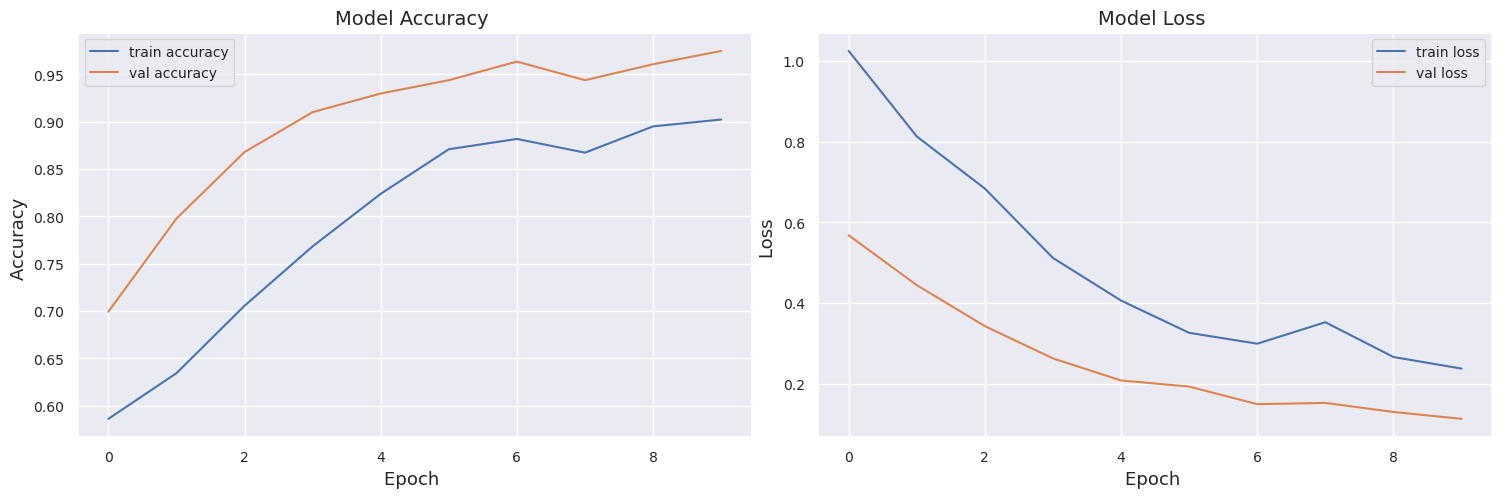

In [39]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']
    
# Plot the accuracy graph and the loss graph
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


# Plot Accuracy
axes[0].plot(train_acc, label='train accuracy')
axes[0].plot(valid_acc, label='val accuracy')
axes[0].set_title('Model Accuracy ', fontsize=14)
axes[0].set_xlabel('Epoch ', fontsize=13)
axes[0].set_ylabel('Accuracy ', fontsize=13)
axes[0].legend(fontsize=10)


# Plot Loss
axes[1].plot(train_loss, label='train loss')
axes[1].plot(valid_loss, label='val loss')
axes[1].set_title('Model Loss ', fontsize=14)
axes[1].set_xlabel('Epoch ', fontsize=13)
axes[1].set_ylabel('Loss ', fontsize=13)
axes[1].legend(fontsize=10)


plt.tight_layout()
for ax in axes:
    ax.tick_params(labelsize=10)
plt.show()


In [40]:
# Save the feature extractor model
resent50_fe = model.save('ResNet50_fe.h5')

### Fine-tuning the pre-trained model

In [41]:
pretrained_model.trainable = True

In [42]:
print("Number of layers in the base model: ", len(pretrained_model.layers))

Number of layers in the base model:  175


In [43]:
# Fine-tune from this layer
fine_tune_at = 160

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
    layer.trainable = False

In [44]:
# Compile the model again
model.compile(optimizer = optimizers.Adam(learning_rate=base_learning_rate/10), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 5,524,482
Non-trainable params: 18,067,328
_________________________________________

In [46]:
len(model.trainable_variables)

18

In [47]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs


early_stopping = EarlyStopping(monitor='val_loss', patience=2,verbose=1)

history_fine_tune = model.fit(datagen.flow(x_train,y_train,
                                       batch_size=batch_size, 
                                       seed=seed,
                                       shuffle=True),
                            batch_size=batch_size,
                            epochs=total_epochs,
                            initial_epoch=history.epoch[-1],
                            validation_data = datagen.flow(x_val, y_val,
                                       seed=seed),
                            callbacks=[early_stopping]
                            )

Epoch 10/15
26/26 [==============================] - 27s 678ms/step - loss: 0.1803 - accuracy: 0.9288 - val_loss: 0.0585 - val_accuracy: 0.9916
Epoch 11/15
26/26 [==============================] - 15s 593ms/step - loss: 0.1252 - accuracy: 0.9505 - val_loss: 0.0526 - val_accuracy: 0.9916
Epoch 12/15
26/26 [==============================] - 16s 602ms/step - loss: 0.0879 - accuracy: 0.9662 - val_loss: 0.0257 - val_accuracy: 0.9944
Epoch 13/15
26/26 [==============================] - 15s 594ms/step - loss: 0.0549 - accuracy: 0.9771 - val_loss: 0.0167 - val_accuracy: 0.9972
Epoch 14/15
26/26 [==============================] - 16s 620ms/step - loss: 0.0346 - accuracy: 0.9843 - val_loss: 0.0193 - val_accuracy: 0.9944
Epoch 15/15
26/26 [==============================] - 15s 590ms/step - loss: 0.0333 - accuracy: 0.9831 - val_loss: 0.0222 - val_accuracy: 0.9944
Epoch 15: early stopping


In [48]:
train_acc += history_fine_tune.history['accuracy']
valid_acc += history_fine_tune.history['val_accuracy']

train_loss += history_fine_tune.history['loss']
valid_loss += history_fine_tune.history['val_loss']

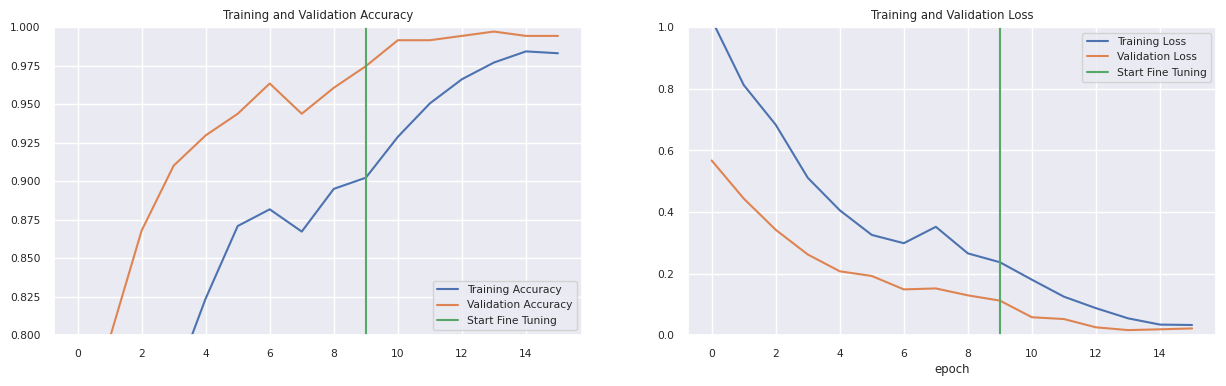

In [49]:
# ref: https://www.tensorflow.org/tutorials/images/transfer_learning
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
loss, acc = model.evaluate(np.array(x_test), to_categorical(y_test))
print('Testing accuracy on unseen data:', round(acc*100,3))
print('Testing loss on unseen data:', round(loss,3))

10/10 [==============================] - 2s 94ms/step - loss: 0.0304 - accuracy: 0.9932
Testing accuracy on unseen data: 99.315
Testing loss on unseen data: 0.03


In [51]:
# Storing the model's accuracies
accuracies_dict['model_name'] = 'ResNet50 - fine-tuned'
accuracies_dict['training_accuracy'] = round(history_fine_tune.history['accuracy'][-1]*100, 3)
accuracies_dict['validation_accuracy'] = round(history_fine_tune.history['val_accuracy'][-1]*100, 3)
accuracies_dict['testing_accuracy'] = round(acc*100,3)
accuracies_list.append(accuracies_dict)
accuracies_dict={}

#### Comparing the performance of both models

In [52]:
performance_df = pd.DataFrame(accuracies_list)
print('Model Performance Scores \n')
performance_df

Model Performance Scores 



model_name  training_accuracy  validation_accuracy  \
0  ResNet50 - feature extraction             90.229               97.472   
1          ResNet50 - fine-tuned             98.311               99.438   

   testing_accuracy  
0            95.205  
1            99.315

In [53]:
# Predictions
predictions = model.predict(np.array(x_test), verbose = 1)
predictions[:5]

10/10 [==============================] - 2s 89ms/step


array([[1.0870149e-02, 9.8912978e-01],
       [9.9955982e-01, 4.4013545e-04],
       [7.1390352e-04, 9.9928612e-01],
       [5.3325906e-02, 9.4667411e-01],
       [2.1525710e-03, 9.9784744e-01]], dtype=float32)

In [54]:
y_true = to_categorical(y_test)
y_true = np.argmax(y_true, axis = 1)
y_pred = np.argmax(predictions, axis = 1)
print('True y      = ', y_true[:8],'\n\nPredicted y = ' ,y_pred[:8])

True y      =  [1 0 1 1 1 0 0 1] 

Predicted y =  [1 0 1 1 1 0 0 1]


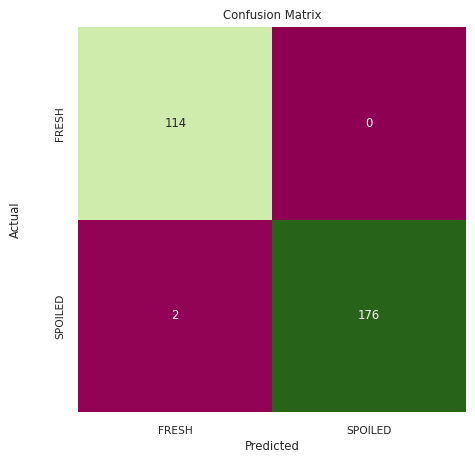

In [55]:
# Printing the confusion matrix and the classification report
class_labels = ['FRESH','SPOILED']
confusion_mat = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names = class_labels)

plt.figure(figsize = (5, 5))
sns.heatmap(confusion_mat, annot = True, vmin = 0, fmt = 'g', cmap = 'PiYG', cbar = False)       
plt.xticks(np.arange(len(class_labels)) + .5, class_labels)
plt.yticks(np.arange(len(class_labels))+.5, class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual\n\n")
plt.title("Confusion Matrix")
plt.show()

In [56]:
print(class_report)

              precision    recall  f1-score   support

       FRESH       0.98      1.00      0.99       114
     SPOILED       1.00      0.99      0.99       178

    accuracy                           0.99       292
   macro avg       0.99      0.99      0.99       292
weighted avg       0.99      0.99      0.99       292



In [57]:
# Save the fine-tune model
resent50_ft = model.save('ResNet50_ft.h5')



In [58]:
# Load the saved model
model1 = tensorflow.keras.models.load_model("ResNet50_ft.h5")

In [59]:
# Function to read the image from the url and process it to suit the model
def image_from_url(url, image_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img1 = img
    img = img.resize((image_size, image_size))
    x = np.array(img)
    tensorflow.keras.applications.resnet.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    return img1, x

1/1 [==============================] - 0s 25ms/step
Predicted class :  FRESH

Classes :  ['FRESH', 'SPOILED'] 


[[0.9915285  0.00847148]]


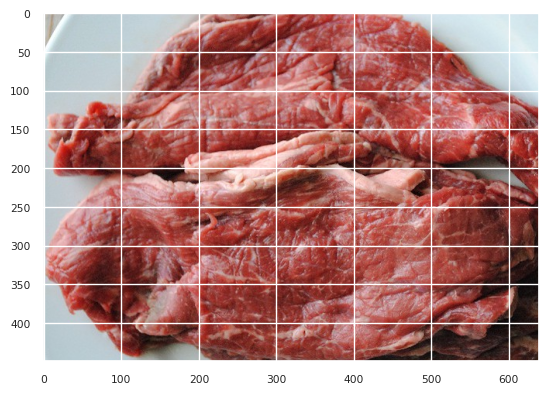

In [63]:
# Predict image from the internet
url = "https://media.istockphoto.com/photos/spoiled-steak-picture-id466978127"
url = 'https://d.newsweek.com/en/full/1789890/high-meat-twitter.webp?w=790&f=1f87f00a4d4f84e9a462cdd272737e83'
url = 'https://farm8.staticflickr.com/7100/7369564888_0ac466fe4d_z.jpg'


image_size = 224 
# call the function defined above
img1, test_img = image_from_url(url, image_size)
pred = model1.predict(test_img) 

classes = list(class_labels_dict.keys())
predicted_class = classes[np.argmax(pred)]
print('Predicted class : ',predicted_class)

plt.imshow(img1)

print('\nClasses : ',classes,'\n\n')
print(pred)